In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import sys

sys.path.insert(0, "/Users/flynnwang/repo/flynn/eco_bang_bang/agents/rule_0202")

In [3]:
sys.path.insert(0, "/Users/flynnwang/repo/flynn/eco_bang_bang/agents")

In [4]:
# from ebb.env.const import *

In [5]:
import torch

from ecobangbang.env.luxenv import get_ob_sapce, LuxS3Env
from ecobangbang.model import _create_model, RewardSpec

reward_spec = RewardSpec(
        reward_min=-5,
        reward_max=+5,
        zero_sum=False,
    )

reward_shaping_params = dict(  new_observed_down_tri=0.0001,
  match_observed=0,
  match_win=1,
  use_hidden_relic_estimator=True,
  energy_cost_change=0.001,                             
)

obs_space_kwargs = {
    'use_energy_cost_map': True,
    'use_single_player': False,
}
env = LuxS3Env(reward_schema='match_explore_win_loss',
               reward_shaping_params=reward_shaping_params,
              obs_space_kwargs=obs_space_kwargs)

obs, reward, done, info = env.reset()

In [6]:
from ecobangbang.agent import Agent

from rule_v3_4a0760b.ecobangbang.agent import Agent as Agent2

# Feature Plots

In [7]:
def plot_imgs(images):
    grid_size = 3
    fig, axes = plt.subplots(grid_size + 1, grid_size, figsize=(10, 10))
    
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            name, img = images[i]
            img = img.T
            ax.imshow(img, cmap='viridis')  # Display image (grayscale here)
            ax.set_title(name, fontsize=8)
            ax.axis('off')  # Turn off the axes
            ax.set_xticks(np.arange(-0.5, img.shape[1], 1))  # Position gridlines at the edges of the pixels
            ax.set_yticks(np.arange(-0.5, img.shape[0], 1))  # Position gridlines at the edges of the pixels
            # Set gridlines to be visible
            ax.grid(which='both', color='black', linestyle='-', linewidth=.5)
        else:
            ax.axis('off')  # Turn off the axes for empty slots
    
    plt.tight_layout()
    plt.show()

In [8]:
from ecobangbang.env.luxenv import LuxS3Env
from ecobangbang.env.const import *


env = LuxS3Env(reward_schema='match_explore_win_loss',
               reward_shaping_params=reward_shaping_params,
              obs_space_kwargs=obs_space_kwargs)
obs, reward, done, info = env.reset(seed=118718427)

def act(a, ob):
    player_id = a.player
    step = ob['steps']
    actions = a.act(step, ob)
    return actions

env_cfg = env.mms[0].env_cfg
a0 = Agent2('player_0', env_cfg)
a1 = Agent('player_1', env_cfg)

============ game step 1 ========== 
============ game step 1 ========== 
 unit[0]=[23 23] assgined to cell=(23, 19), wts={'explore_wt': 3, 'fuel_wt': np.int32(0), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(0.3875968992248062), 'wt': np.float64(1.8628639691774649), 'mdist': np.float64(1.6105100000000006)}
game_step=1 sending unit=0 pos=[23 23] to cell=(23, 19)
game_step=1, unit=0 action=ACTION_UP, cost=3.0
game_step=1, unit=0 action=ACTION_LEFT, cost=8.0
============ game step 2 ========== 
 unit[0]=[23 22] assgined to cell=(23, 18), wts={'explore_wt': 3, 'fuel_wt': np.int32(0), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(0.38671875), 'wt': np.float64(1.8628639691774649), 'mdist': np.float64(1.6105100000000006)}
game_step=2 sending unit=0 pos=[23 22] to cell=(23, 18)
game_step=2, unit=0 action=ACTION_UP, cost=9.0
game_step=2, unit=0 action=ACTION_DOWN, cost=13.0
game_step=2, unit=0 action=ACTIO

294.0 92.0
number of units: 3


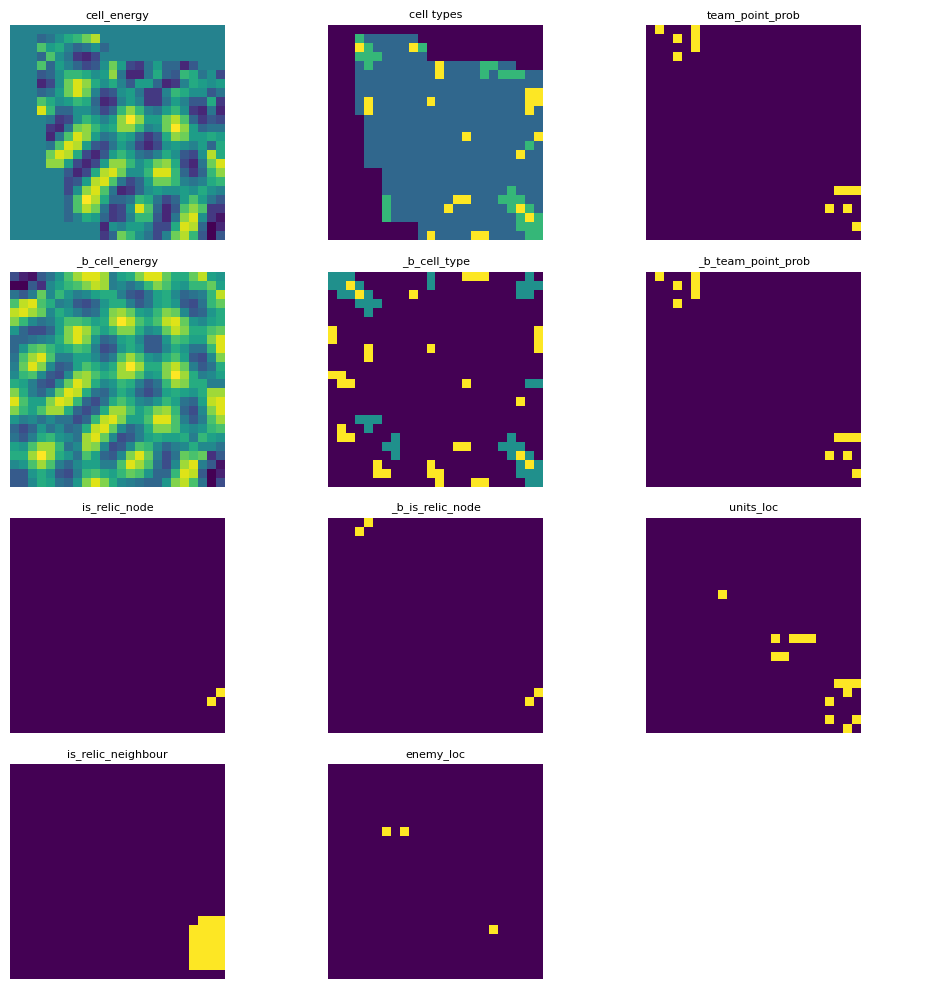

In [9]:
for i in range(293+1):
    action0 = act(a0, env.mms[0].past_obs[0])
    action1 = act(a1, env.mms[1].past_obs[0])
    player_actions = [{UNITS_ACTION: action0}, {UNITS_ACTION: action1}]
    obs, reward, done, info = env.step(player_actions)

PLAYER_ID = 1
ob = obs[PLAYER_ID]
print(ob['game_step'][0][0][0] * 505, ob['match_step'][0][0][0] * 100)

units_loc = ob['units_loc_t0']
units_energy = ob['units_energy_t0']
nebula_tile_vision_reduction = ob['nebula_tile_vision_reduction']
enemy_loc = ob['enemy_loc_t0']

nu = env.mms[PLAYER_ID].past_obs[0]['units_mask'][0].sum()
print(f'number of units: {nu}')

plot_imgs([('cell_energy', ob['_a_cell_energy']), ('cell types', ob['_a_cell_type']), ('team_point_prob', ob['_a_team_point_prob']),
           ('_b_cell_energy', ob['_b_cell_energy']), ('_b_cell_type', ob['_b_cell_type']), ('_b_team_point_prob', ob['_b_team_point_prob']),    
            ('is_relic_node', ob['_a_is_relic_node']), ('_b_is_relic_node', ob['_b_is_relic_node']),  
           ('units_loc', units_loc > 0),  ('is_relic_neighbour', ob['is_relic_neighbour']), ('enemy_loc', enemy_loc > 0) 
           ])

In [14]:
from ecobangbang.env.luxenv import *
from ecobangbang.agent import *

In [15]:
self = a1

mm = self.mm
is_explore_step = (mm.match_step <= 50 and mm.game_step < 303)

match_observed = mm.match_observed + anti_diag_sym(mm.match_observed)
energy_threshold = 60 + (100 - self.mm.match_step) * 2
if mm.match_step >= 50:
  energy_threshold = self.mm.unit_sap_cost + self.mm.unit_sap_cost

def get_explore_weight(upos, energy, cpos):
  alpha = 1

  # last_ob_time = mm.last_observed_step[cpos[0]][cpos[1]]
  # t = mm.game_step - last_ob_time
  # alpha = np.log(t + 1) / LOGX

  if match_observed[cpos[0]][cpos[1]]:
    return 0

  wt = 3
  if not is_explore_step:
    wt /= 5

  return wt * alpha

energy_map = mm.cell_energy.copy()
energy_map[mm.cell_energy != CELL_UNKONWN] -= mm.unit_move_cost
energy_map[mm.cell_type == CELL_NEBULA] -= mm.nebula_energy_reduction

def get_fuel_energy(upos, energy, cpos):
  fuel = energy_map[cpos[0]][cpos[1]]
  fuel = right_tailed_exp(energy, fuel, energy_threshold)
  return fuel

def get_open_relic_nb(upos, energy, cpos):
  """First visit on relic neighbour"""
  if not mm.is_relic_neighbour[cpos[0]][cpos[1]]:
    return 0

  # if not mm.match_visited[cpos[0]][cpos[1]]:
  # return RELIC_NB_SCORE

  p = mm.team_point_mass[cpos[0]][cpos[1]]
  if p < 0.1:
    return 0

  last_visited_step = mm.last_visited_step[cpos[0]][cpos[1]]
  t = mm.game_step - last_visited_step
  alpha = np.log(t + 1) / LOG3
  w = min(alpha, 1) * RELIC_NB_SCORE

  # if on_enemy_side(cpos, mm.player_id):
  # w = left_tailed_exp(energy, w, energy_threshold)

  cpos_nb_mask = gen_sap_range(cpos, self.mm.unit_sap_range)
  if (mm.enemy_max_energy[cpos_nb_mask] > energy).sum() > 0:
    w = left_tailed_exp(energy, w, energy_threshold)
    # w /= 2

  return w

def stay_on_relic(upos, energy, cpos):
  p = mm.team_point_mass[cpos[0]][cpos[1]]
  w = 0
  if p > 0.8:
    w += RELIC_SCORE * p

  # if on_enemy_side(cpos, mm.player_id):

  cpos_nb_mask = gen_sap_range(cpos, self.mm.unit_sap_range)
  if (mm.enemy_max_energy[cpos_nb_mask] > energy).sum() > 0:
    w = left_tailed_exp(energy, w, energy_threshold)
  return w

hit_factor = 10
enemy_hit_map = self.get_sap_hit_map(hit_factor)
self.enemy_hit_map = enemy_hit_map

def get_sap_enemy_score(upos, energy, cpos):
  """Max sap damage that could be hit from the `cpos`."""
  if not can_attack(energy, mm):
    return 0

  # sap_range = np.ones((MAP_WIDTH, MAP_HEIGHT), dtype=bool)
  # sap_range = generate_manhattan_mask(sap_range, cpos,
  # self.mm.unit_sap_range)
  sap_range = gen_sap_range(cpos, self.mm.unit_sap_range)

  h = enemy_hit_map[sap_range].max()
  h /= hit_factor

  # h = left_tailed_exp(energy, h, energy_threshold)
  # h *= (energy / 200)

  # sap if energy is large
  h *= max((energy / energy_threshold), 1)
  return h

score_debug = {}

def get_unit_cell_wt(upos, energy, cpos, unit_cost_map):
  if cant_move_to(upos, cpos, mm):
    return -9999

  if energy < unit_cost_map[cpos[0]][cpos[1]]:
    # if not SUBMIT_AGENT:
    # print(f'game_step={mm.game_step}: skip due to inf at {cpos}',
    # file=sys.stderr)
    return -9999

  # Do not target cell with enemy energy > unit energy
  if energy < mm.enemy_max_energy[cpos[0]][cpos[1]]:
    return -9999

  # mdist = manhatten_distance(upos, cpos) + 7
  mdist = dd(manhatten_distance(upos, cpos) + 1)
  wt = 0.0001

  energy_ratio = energy / energy_threshold

  expore_wt = 0
  if energy >= 50:
    expore_wt = get_explore_weight(upos, energy, cpos)

  fuel_wt = get_fuel_energy(upos, energy, cpos)

  relic_nb_wt = get_open_relic_nb(upos, energy, cpos)

  on_relic_wt = stay_on_relic(upos, energy, cpos)

  sap_wt = get_sap_enemy_score(upos, energy, cpos)

  wt += (expore_wt + fuel_wt + relic_nb_wt + on_relic_wt + sap_wt) / mdist

  score_debug[(tuple(upos), tuple(cpos))] = {
      'explore_wt': expore_wt,
      'fuel_wt': fuel_wt,
      'relic_nb_wt': relic_nb_wt,
      'on_relic_wt': on_relic_wt,
      'sap_wt': sap_wt,
      'energy_ratio': energy_ratio,
      'wt': wt,
      'mdist': mdist,
  }
  return wt



upos = (22, 20)
unit_cost_map = self.compute_energy_cost_map(upos, asteriod_cost=75)

cpos = (22, 14)
energy = 60
get_unit_cell_wt(upos, energy, cpos, unit_cost_map)

np.float64(4.875102123191711)

In [17]:
cpos = (22, 14)
energy = 60
get_unit_cell_wt(upos, energy, upos, unit_cost_map)

np.float64(39.54555454545454)

In [18]:
score_debug

{((22, 20), (22, 14)): {'explore_wt': 0,
  'fuel_wt': np.float64(5.0),
  'relic_nb_wt': 0,
  'on_relic_wt': 0,
  'sap_wt': np.float64(4.5),
  'energy_ratio': 1.0,
  'wt': np.float64(4.875102123191711),
  'mdist': 1.9487171000000012},
 ((22, 20), (22, 20)): {'explore_wt': 0,
  'fuel_wt': np.float64(-6.0),
  'relic_nb_wt': np.float64(15.0),
  'on_relic_wt': np.float64(30.0),
  'sap_wt': np.float64(4.5),
  'energy_ratio': 1.0,
  'wt': np.float64(39.54555454545454),
  'mdist': 1.1}}

In [ ]:
mm.get_unit_info(mm.player_id, i=0, t=0)

In [ ]:
cost = a1.compute_energy_cost_map((23, 23), asteriod_cost=75)

In [ ]:
plot_imgs([('cost', cost), ])

In [ ]:
from ecobangbang.agent import *

In [ ]:
self = a1


mdist = dd(manhatten_distance(upos, cpos) + 1)
wt = 0.0001

energy_ratio = energy / energy_threshold

expore_wt = 0
if energy >= 50:
expore_wt = get_explore_weight(upos, energy, cpos)

fuel_wt = get_fuel_energy(upos, energy, cpos)

relic_nb_wt = get_open_relic_nb(upos, energy, cpos)

on_relic_wt = stay_on_relic(upos, energy, cpos)

sap_wt = get_sap_enemy_score(upos, energy, cpos)

wt += (expore_wt + fuel_wt + relic_nb_wt + on_relic_wt + sap_wt) / mdist

score_debug[(tuple(upos), tuple(cpos))] = {
  'explore_wt': expore_wt,
  'fuel_wt': fuel_wt,
  'relic_nb_wt': relic_nb_wt,
  'on_relic_wt': on_relic_wt,
  'sap_wt': sap_wt,
  'energy_ratio': energy_ratio,
  'wt': wt,
  'mdist': mdist,
}
return wt



upos = (23, 23)
cost = a1.compute_energy_cost_map(upos, asteriod_cost=75)

get_unit_cell_wt(upos, 94, (23, 22), cost)

In [ ]:
get_unit_cell_wt(upos, 94, (23, 23), cost)

In [ ]:
get_unit_cell_wt(upos, 94, (23, 20), cost)

In [ ]:
score_debug

In [ ]:
right_tailed_exp(100, 3, 60)

In [ ]:
energy_map[upos], mm.unit_move_cost

In [ ]:
hit_map = np.zeros((MAP_WIDTH, MAP_HEIGHT), dtype=float)

for i in range(MAX_UNIT_NUM):
  mask, pos, energy = self.mm.get_unit_info(self.mm.enemy_id, i, t=0)
  if not mask:
    continue

  if self.mm.enemy_positions[pos[0]][pos[1]]:
    p = self.mm.team_point_mass[pos[0]][pos[1]]
    hit_map[pos[0]][pos[1]] += (RELIC_SCORE * (p**2))

  for d in [1, 0]:
    x0 = max(0, (pos[0] - d))
    x1 = min(MAP_WIDTH, (pos[0] + d + 1))
    y0 = max(0, (pos[1] - d))
    y1 = min(MAP_HEIGHT, (pos[1] + d + 1))

    h = self.mm.unit_sap_cost
    if d == 1:
      h *= self.mm.unit_sap_dropoff_factor
    hit_map[x0:x1, y0:y1] += h

cpos = upos
sap_range = gen_sap_range(cpos, self.mm.unit_sap_range)

In [ ]:
plot_imgs([('enemy_hit_map', enemy_hit_map), ('mm.enemy_positions', mm.enemy_positions), ('hit_map', hit_map),
           ('sap_range', sap_range), ])

In [ ]:
print("============ game step 468 ========== \nunit[[9 3]] and cell ((1, 0)) wt={'explore_wt': 0, 'fuel_wt': -3.726653172078671e-05, 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': 0.0, 'energy_ratio': 2.25, 'wt': 8.81257345245768e-05, 'mdist': 3.138428376721003}\nunit[[9 3]] and cell ((2, 0)) wt={'explore_wt': 0, 'fuel_wt': -2.9813225376629368e-05, 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': 0.0, 'energy_ratio': 2.25, 'wt': 8.955064638162758e-05, 'mdist': 2.8531167061100025}\nunit[[9 3]] and cell ((3, 0)) wt={'explore_wt': 0, 'fuel_wt': -1.8633265860393355e-05, 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': 0.0, 'energy_ratio': 2.25, 'wt': 9.281606938736897e-05, 'mdist': 2.5937424601000023}\nunit[[9 3]] and cell ((4, 0)) wt={'explore_wt': 0, 'fuel_wt': -7.453306344157342e-06, 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': 0.0, 'energy_ratio': 2.25, 'wt': 9.683907053044235e-05, 'mdist': 2.357947691000002}\nunit[[9 3]] and cell ((5, 0)) wt={'explore_wt': 0, 'fuel_wt': 3.726653172078671e-06, 'relic_nb_wt': 0, 'on_relic_wt': ")